**Implementing Word2Vector Model using Pytorch for MCA Winter 2020**
- Reference : https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281 

- Reference : https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf 

- Reference : https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/ 

**Importing the NTLK 'abc' corpus text**



In [1]:
import nltk
from nltk.corpus import abc
nltk.download('abc')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
import numpy as np
import torch
import itertools
import re
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Get sentence out of the data**

In [61]:
nltk.download('punkt')
data = [" ".join(list_of_words) for list_of_words in abc.sents()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
#print(len(data))
new_data = data[0:50]
print(len(new_data))

50



**Pre Processing and Tokenize**

In [0]:

def preprocess_tokenize_text(new_data):

  corpus = []

  for sentence in new_data:
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', sentence)
    text = re.sub(' +', ' ', text)
    text.replace('\n', ' ')
    text = re.sub(r'[0-9]+', '', text)
    text = text.lower()
    text.strip()
    
    corpus.append([w for w in text.split() if w != ''])
  return corpus

tokenized = preprocess_tokenize_text(new_data)

**Make Dictionary for Mapping**
- This is necessary step to reduce exclude the repetitive words

In [0]:
dictionary = []
for sent in tokenized:
  for word in sent:

    if (word not in dictionary): # Only update if the word is not present in the dictionary

      dictionary.append(word)

word_to_index = {word: index for (index, word) in enumerate(dictionary)}

index_to_word = {index: word for (index, word) in enumerate(dictionary)}    

**Find Center Word and Context Word**



In [0]:
dict_sz = len(dictionary)

window_size = 2
index_pairs = []

for sentence in tokenized:

    indices = []
    for each_word in sentence:
      wrd = word_to_index[each_word]
      indices.append(wrd)

         
    for cw_pos in range(len(indices)):
        
        for w in range(-window_size, window_size + 1):

            conw_pos = cw_pos + w
            
            if (conw_pos < 0) or (conw_pos >= len(indices)) or (cw_pos == conw_pos):
                continue

            conW_idx = indices[conw_pos]
            index_pairs.append((indices[cw_pos], conW_idx))

index_pairs = np.array(index_pairs)

**Making Neural Network**

In [71]:
def get_input_layer(word_index):
    inp_layer = torch.zeros(dict_sz).float()
    inp_layer[word_index] = 1.0
    return inp_layer

embedding_dims = dict_sz
W1 = Variable(torch.randn(embedding_dims, dict_sz).float(), requires_grad=True)
W2 = Variable(torch.randn(dict_sz, embedding_dims).float(), requires_grad=True)
print(W1.size())
print(W2.size())
num_epochs = 10
learning_rate = 0.01
loss_array = []
for epoch in range(num_epochs):

    loss_value = 0
    
    for data, target in index_pairs:

        x = Variable(get_input_layer(data)).float()
        t_ini = np.array([target])

        label_Y = Variable(torch.from_numpy(t_ini).long())

        mult_1 = torch.matmul(W1, x)
        mult_2 = torch.matmul(W2, mult_1)
    
        log_softmax = F.log_softmax(mult_2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), label_Y)
        loss_value += loss.data

        loss.backward()

        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    total = len(index_pairs)
    t_loss = loss_value/total 
    loss_array.append(t_loss)

# Print Loss per epoch    
for i in range(num_epochs):
  print('Loss at epoch', i , ':', loss_array[i])    

## Saving the weights of the model
np.save('/content/drive/My Drive/Assignment 2/'+'saved_w1.npy', W1.detach().numpy())
np.save('/content/drive/My Drive/Assignment 2/'+'saved_w2.npy', W2.detach().numpy())   

torch.Size([488, 488])
torch.Size([488, 488])
Loss at epoch 0: 48.637020111083984
Loss at epoch 1: 30.3354434967041
Loss at epoch 2: 21.406906127929688
Loss at epoch 3: 16.05221939086914
Loss at epoch 4: 12.676362991333008
Loss at epoch 5: 10.703826904296875
Loss at epoch 6: 9.641138076782227
Loss at epoch 7: 9.130559921264648
Loss at epoch 8: 8.895503997802734
Loss at epoch 9: 8.80825138092041


**Loss vs Epoch**

[tensor(48.6370), tensor(30.3354), tensor(21.4069), tensor(16.0522), tensor(12.6764), tensor(10.7038), tensor(9.6411), tensor(9.1306), tensor(8.8955), tensor(8.8083)]


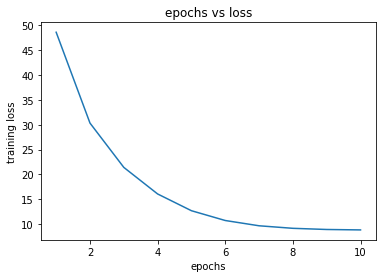

In [72]:
import matplotlib.pyplot as plt

x = []
for i in range(num_epochs):
  x.append(i+1)

y = loss_array
print(y)  
plt.plot(x, y) 
  
plt.xlabel('epochs') 

plt.ylabel('training loss') 
  
plt.title('epochs vs loss') 

plt.show() 

**Function to Find the Word Vector for a particular word**

In [0]:
def word_vec(W1, word):
	w_index = word_to_index[word]
	vector_w = W1[w_index]
	return vector_w

**Function to Find Similar words from the embedding**


In [0]:
def similar_words(word, n,w1,dict_sz):
  v_w1 = word_vec(W1,word)
  #print(v_w1.size())
  # convert this torch.tensor to numpy for ease in computing
  v_w1 = v_w1.data.numpy()

  # dictionary to store the similar words
  word_sim = {}

  for i in range(dict_sz):
    v_w2 = w1[i]
    #print(v_w2.size())
    v_w2 = v_w2.data.numpy()
    theta_sum = np.dot(v_w1, v_w2)
    theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
    theta = theta_sum / theta_den

    word = index_to_word[i]
    word_sim[word] = theta
    
    all_words = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)
    
  #for word, sim in words_sorted[:top_n]:
  #  print(word, sim)
  return(all_words[:n])  
   
#vec_sim('twitter',20,W1,dict_sz)

**To Reload the model weights**

*   Make sure to enter the correct adderss




In [0]:
w1_loaded = numpy.load('saved_w1.npy')
w2_loaded = numpy.load('saved_w2.npy')

**Make Plot of similiar word embeddings**
- Reference : https://github.com/sismetanin/word2vec-tsne/blob/master/Visualizing%20Word2Vec%20Word%20Embeddings%20using%20t-SNE.ipynb 

torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

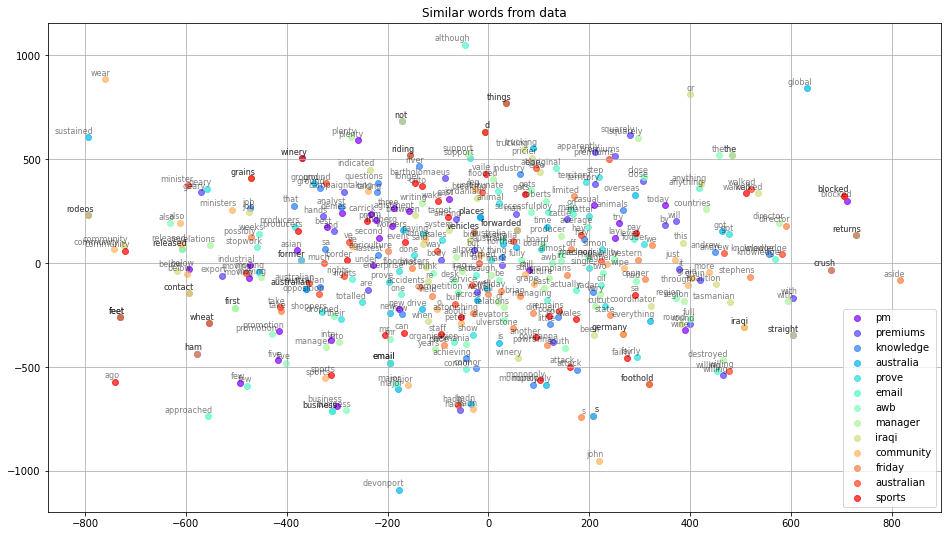

In [93]:
keys = ['pm', 'premiums', 'knowledge', 'australia', 'prove', 'email', 'awb', 'manager', 'iraqi','community','friday','australian','sports']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in similar_words(word,30,W1,dict_sz):
        words.append(similar_word)
        embeddings.append(word_vec(W1,similar_word).data.numpy())
    embedding_clusters.append(embeddings)
    word_clusters.append(words)



from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from data', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')



**Make gif of Word Embedding for similar words**
- Reference : https://github.com/sismetanin/word2vec-tsne/blob/master/Visualizing%20Word2Vec%20Word%20Embeddings%20using%20t-SNE.ipynb 

torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])
torch.Size([488])


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

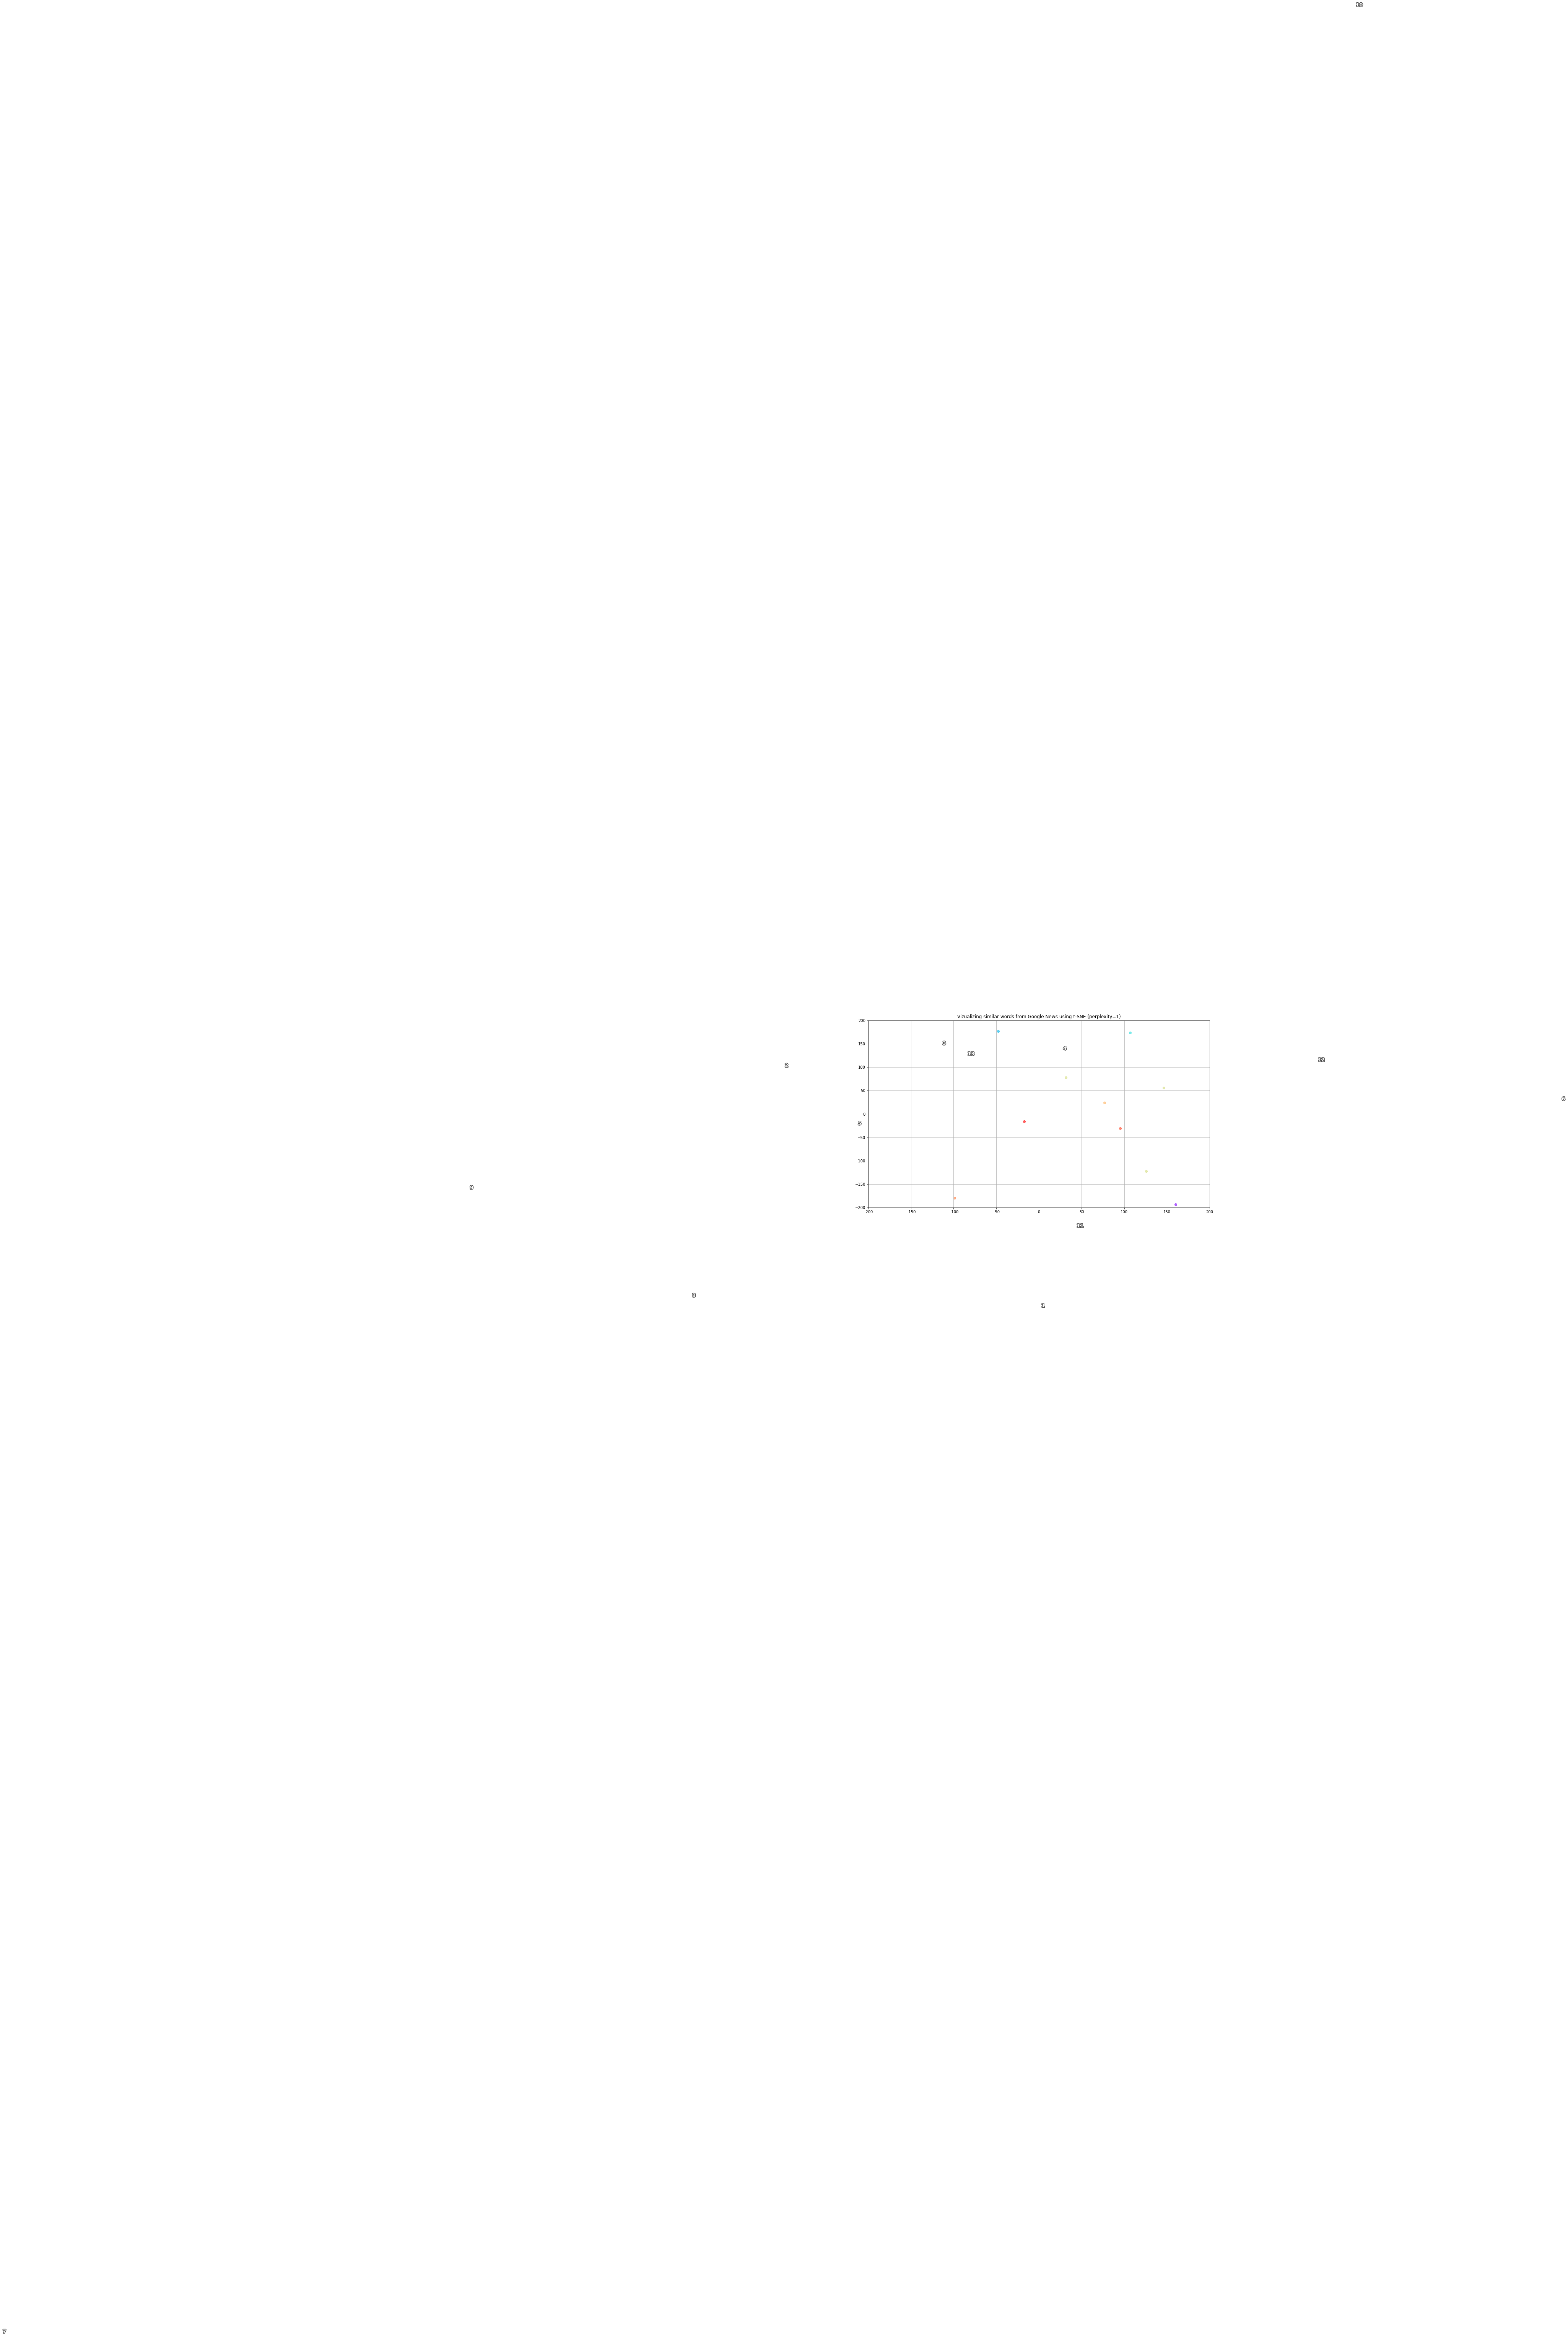

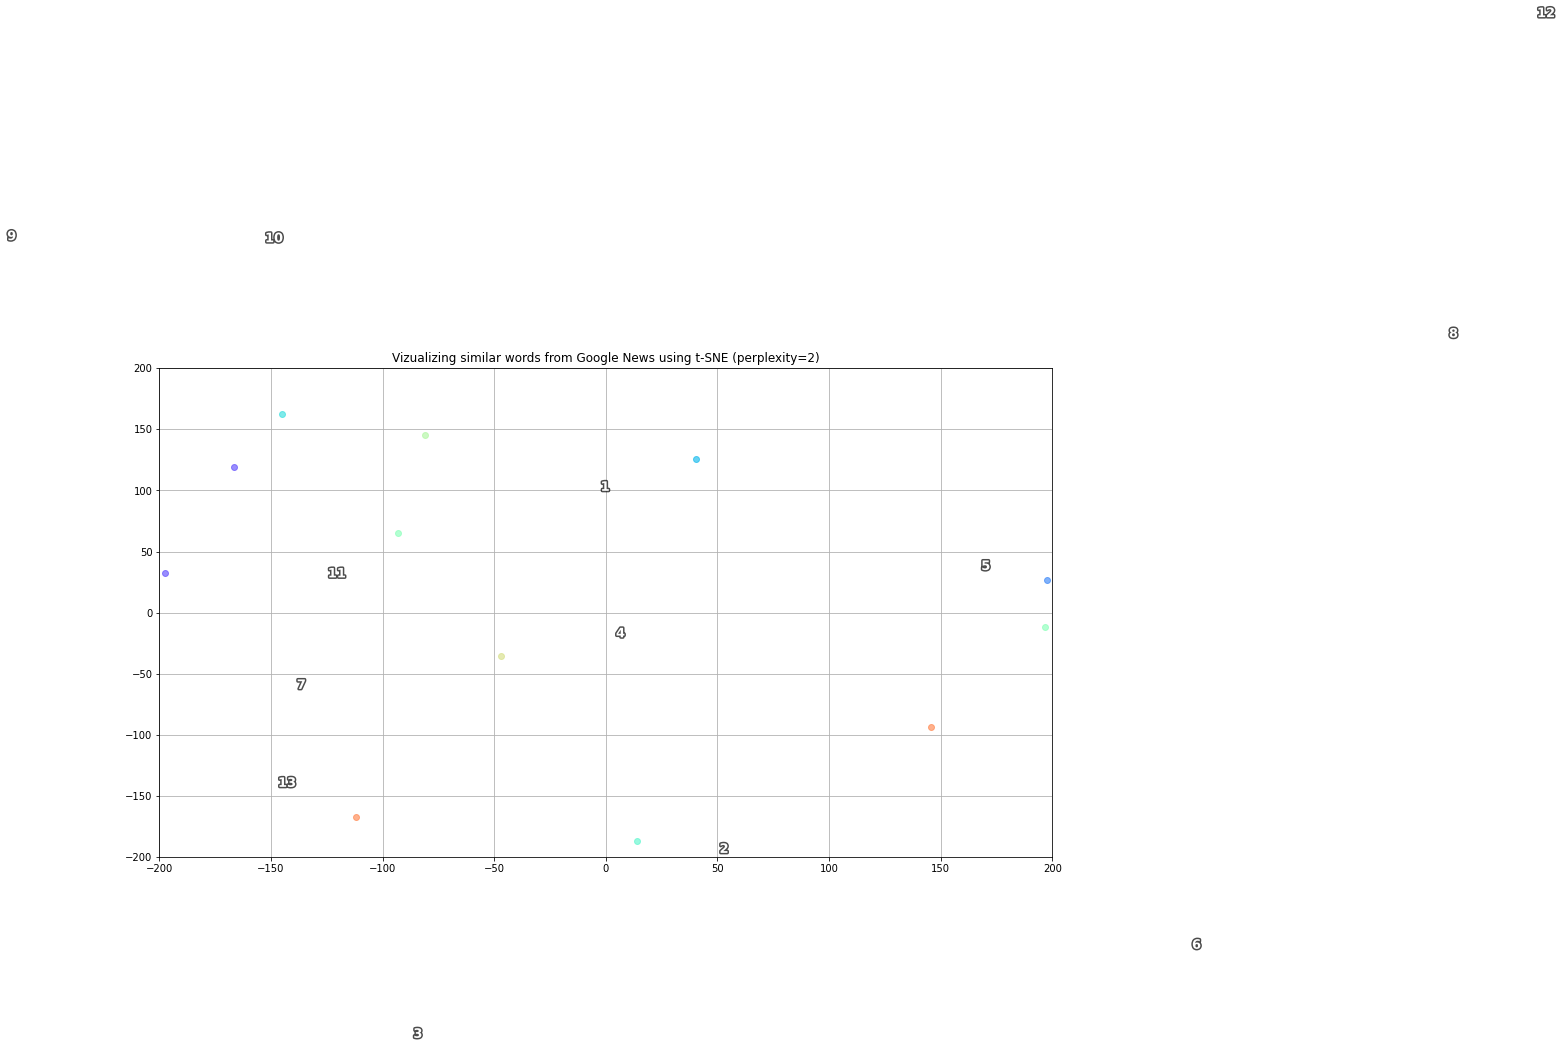

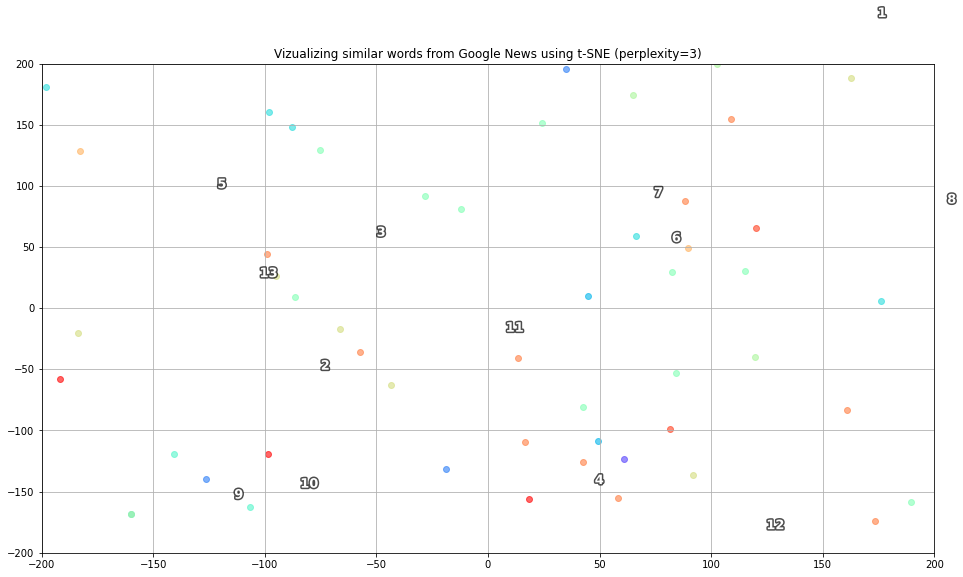

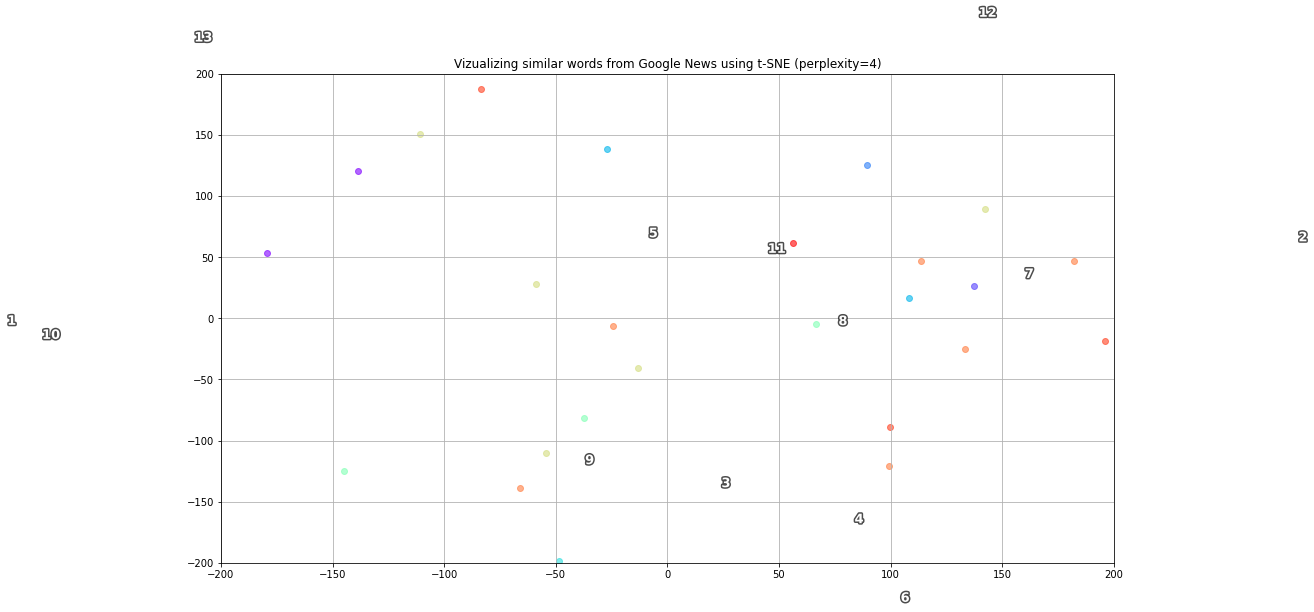

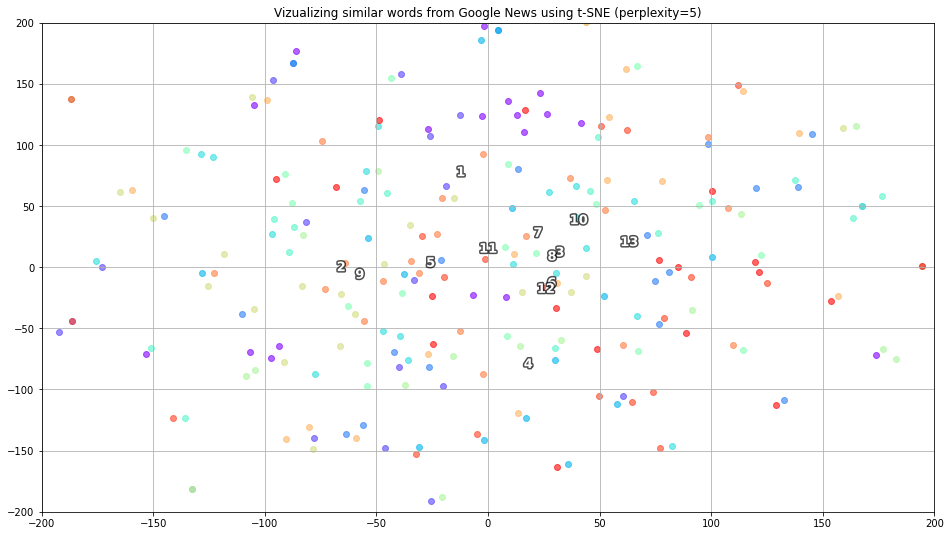

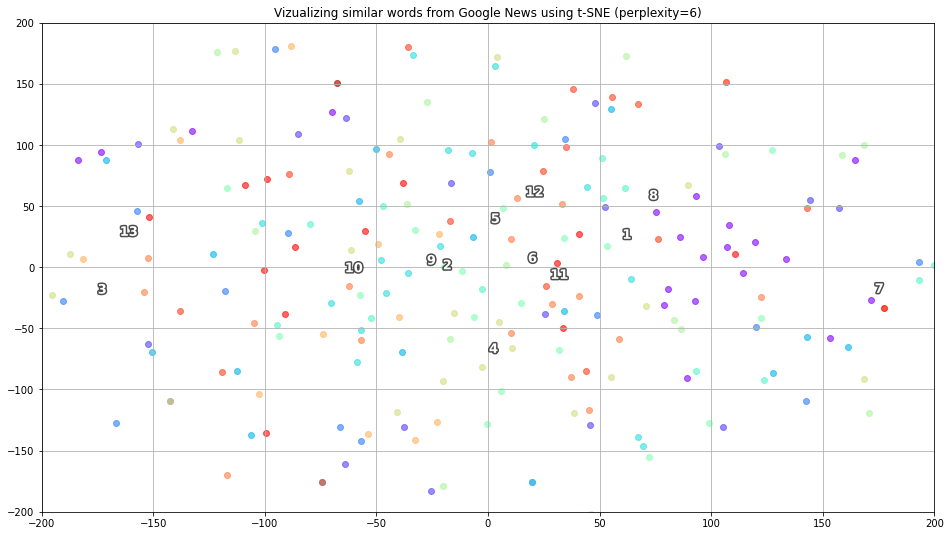

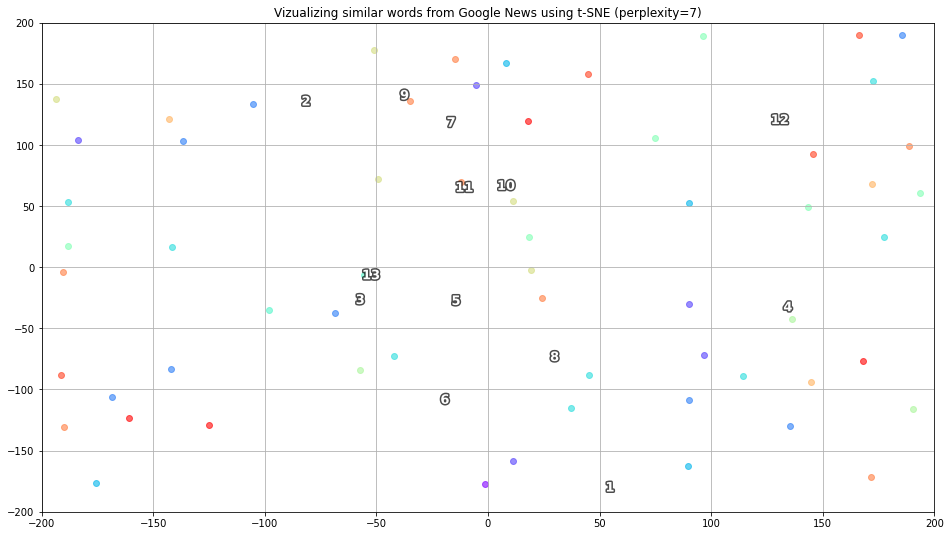

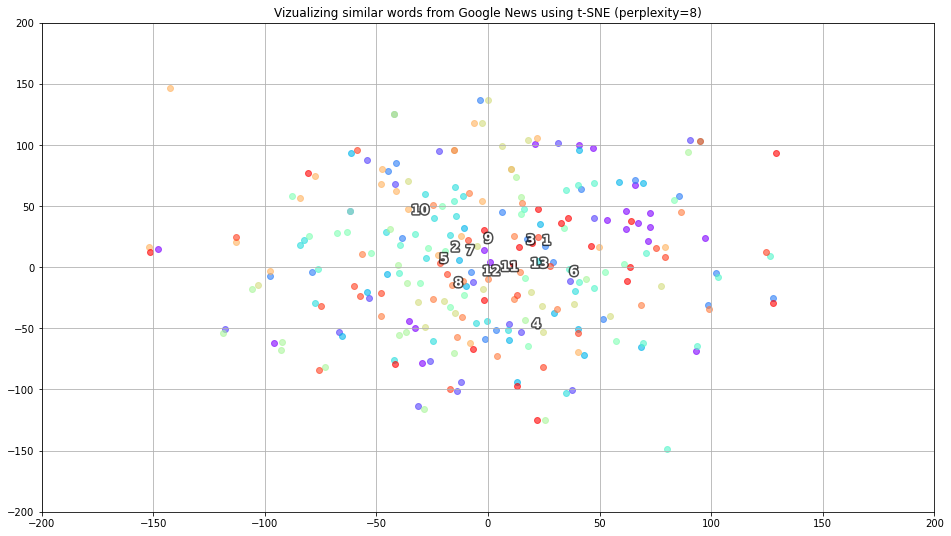

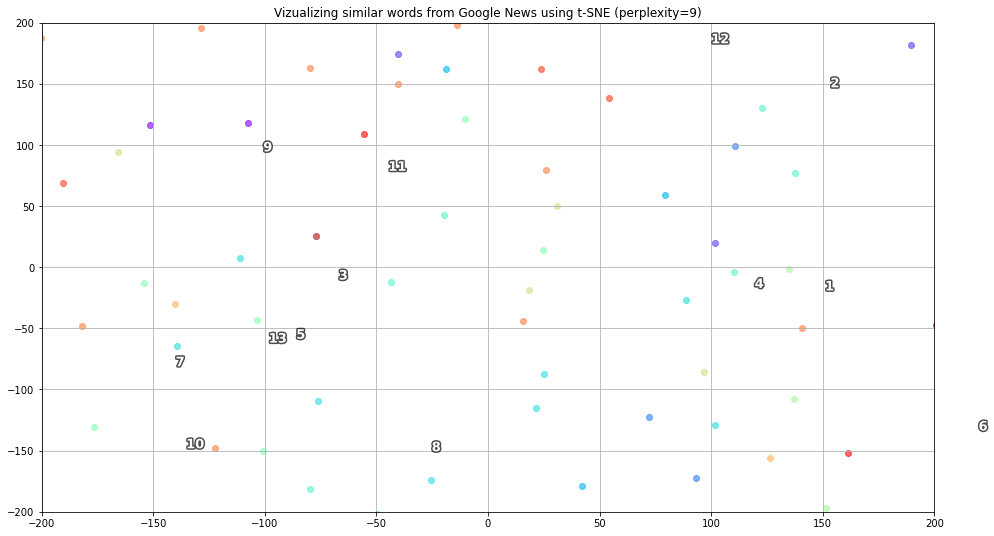

In [94]:
import os
keys = ['pm', 'premiums', 'knowledge', 'australia', 'prove', 'email', 'awb', 'manager', 'iraqi','community','friday','australian','sports']

embedding_clusters_gif = []
word_clusters_gif = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in vec_sim(word, 20,W1,dict_sz):
        words.append(similar_word)
        embeddings.append(word_vec(W1,similar_word).data.numpy())
    embedding_clusters_gif.append(embeddings)
    word_clusters_gif.append(words)


from sklearn.manifold import TSNE
import numpy as np

embedding_clusters_gif = np.array(embedding_clusters_gif)
n, m, k = embedding_clusters_gif.shape

import matplotlib.patheffects as PathEffects
import tempfile
import imageio
import shutil

def tsne_plot_similar_words_png(title, embedding_clusters, a, filename):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))
    i = 1
    for embeddings, color in zip(embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a)
        plt.text(x.mean(), y.mean(), str(i), color='white', weight='bold', fontsize=13, path_effects=[PathEffects.withStroke(linewidth=3,
                                                                          foreground="black", alpha=0.7)])
        i += 1
    plt.title(title)
    plt.grid(True)
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    

dirpath = tempfile.mkdtemp()
images = []
for i in range(1, 10):
    fname = os.path.join(dirpath, str(i) + '.png')
    tsne_model_en_2d_gif = TSNE(perplexity=i, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d_gif = np.array(tsne_model_en_2d_gif.fit_transform(embedding_clusters_gif.reshape(n * m, k))).reshape(n, m, 2)
    tsne_plot_similar_words_png('Vizualizing similar words from Google News using t-SNE (perplexity={})'.format(i), embeddings_en_2d_gif, 0.6, fname)
    images.append(imageio.imread(fname))
imageio.mimsave("2d1.gif", images, duration = 0.5)
shutil.rmtree(dirpath)